# Demonstration: Trilateration With Noise!

In lecture, we learned how the GPS receiver determines its location once it knows the distance of the various signaling beacons from itself.
This method is called *trilateration*.

In this demonstration, we're going to further explore the connection between trilateration and least squares through a toy problem with four beacons and one GPS receiver.

<img src="figs/reallybadfigurefortriangulation.png">
We are given *three* possible sets of measurements for the distances of each of the beacons from the receiver:

1. First, the ideal set of measurements. $d_1 = d_2 = d_3 = d_4 = 5$.
2. Next, a set of imperfect measurements. $d_1 = 5, d_2 = 4.8, d_3 = 5, d_4 = 5.2$.
3. Finally, a set of mostly perfect measurements, but $d_1$ is a very bad measurement. We have $d_1 = 6.5$ and $d_2 = d_3 = d_4 = 5$.

First, we set up some notation for the positions of the beacons, as well as their respective distances from the receivers.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpld3
mpld3.enable_notebook()
import plotly.plotly as py
from plotly.graph_objs import *


axis = dict(
    showbackground=True,                  # (!) show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
    range=[-10, 10]
)

axisZ = dict(
    showbackground=True,                  # (!) show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
    range=[0, 600]
)
# Make a layout object
layout = Layout(
    title='Cost Map',   # set plot title
    scene=Scene(            # (!) axes are part of a 'scene' in 3d plots
        xaxis=XAxis(axis),  # set x-axis style
        yaxis=YAxis(axis),  # set y-axis style
        zaxis=ZAxis(axisZ),  # set z-axis style
    ),
    showlegend=False,
)


%matplotlib inline
py.sign_in('ee16a', '2eqa3edyhn')


################ LOOK HERE ######################
distances = np.array([7.5, 5, 5, 5]) # Right now, it contains the ideal set of measurements. Change the data for the second and third sets.
positions = [(0,-5),(-5/2.0,5*np.sqrt(3)/2),(0,5),(5/2.0,5*np.sqrt(3)/2)]
xpositions = np.array([positions[0][0], positions[1][0], positions[2][0], positions[3][0]])
ypositions = np.array([positions[0][1], positions[1][1], positions[2][1], positions[3][1]])

Now, let's plot the circles for each of the beacons corresponding to the respective distances of the receiver from each of them. The rough intersection of the circles will tell us, intuitively, where the receiver is located! (Note that the circles do not necessarily intersect at one point! Why?)

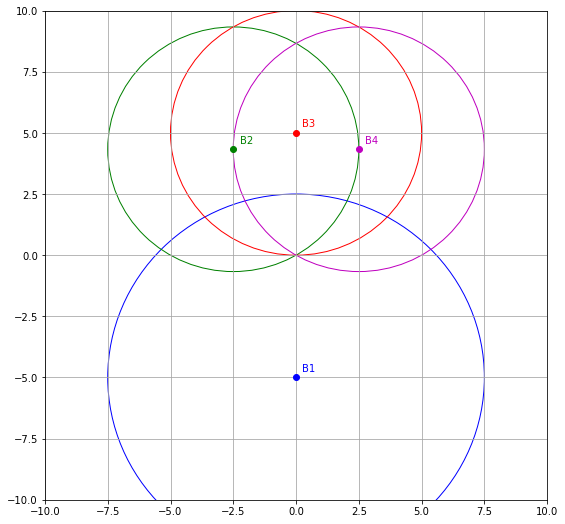

In [60]:
circle1 = plt.Circle(positions[0],distances[0],color='b',fill=False)
circle2 = plt.Circle(positions[1],distances[1],color='g',fill=False)
circle3 = plt.Circle(positions[2],distances[2],color='r',fill=False)
circle4 = plt.Circle(positions[3],distances[3],color='m',fill=False)

fig = plt.figure(figsize=(9,9))
ax=fig.add_subplot(111,xlim=[-10,10],ylim=[-10,10])
ax.plot(positions[0][0], positions[0][1], 'bo')
ax.text(positions[0][0] + 0.25, positions[0][1] + 0.25, "B1", color='b')
ax.plot(positions[1][0], positions[1][1],'go')
ax.text(positions[1][0] + 0.25, positions[1][1] + 0.25, "B2", color='g')
ax.plot(positions[2][0], positions[2][1],'ro')
ax.text(positions[2][0] + 0.25, positions[2][1] + 0.25, "B3", color='r')
ax.plot(positions[3][0], positions[3][1],'mo')
ax.text(positions[3][0] + 0.25, positions[3][1] + 0.25, "B4", color='m')
fig.gca().add_patch(circle1)
fig.gca().add_patch(circle2)
fig.gca().add_patch(circle3)
fig.gca().add_patch(circle4)
ax.grid(b=True, which='both', color='0.65',linestyle='-')

Now, let's solve for the location of the receiver, $\begin{bmatrix}x_1 \\ x_2\end{bmatrix}$, using least squares.

Recall that we made the system of equations linear by subtracting each of the equations for the beacon from the equation for the first beacon.

This will result in the system of equations:
\begin{equation}
(data\_matrix)\begin{bmatrix}x_1\\x_2\end{bmatrix} = values
\end{equation}

We have defined $data\_matrix$ and $values$ in the code blocks below.

In [61]:
data_matrix = np.zeros((3,2))
data_matrix[0][0] = 2*(xpositions[0] - xpositions[1])
data_matrix[0][1] = 2*(ypositions[0] - ypositions[1])
data_matrix[1][0] = 2*(xpositions[0] - xpositions[2])
data_matrix[1][1] = 2*(ypositions[0] - ypositions[2])
data_matrix[2][0] = 2*(xpositions[0] - xpositions[3])
data_matrix[2][1] = 2*(ypositions[0] - ypositions[3])
print(data_matrix)

[[  5.         -18.66025404]
 [  0.         -20.        ]
 [ -5.         -18.66025404]]


In [62]:
values = np.zeros(3)
values[0] = xpositions[0]*xpositions[0] - xpositions[1]*xpositions[1] + ypositions[0]*ypositions[0] - ypositions[1]*ypositions[1] - distances[0]*distances[0]+distances[1]*distances[1]
values[1] = xpositions[0]*xpositions[0] - xpositions[2]*xpositions[2] + ypositions[0]*ypositions[0] - ypositions[2]*ypositions[2] - distances[0]*distances[0]+distances[2]*distances[2]
values[2] = xpositions[0]*xpositions[0] - xpositions[3]*xpositions[3] + ypositions[0]*ypositions[0] - ypositions[3]*ypositions[3] - distances[0]*distances[0]+distances[3]*distances[3]
print(values)

[-31.25 -31.25 -31.25]


Now, we calculate the linear least squares estimate. Let's see what this gives us for the position of the receiver!

In [63]:
U1 = np.dot(data_matrix.T,data_matrix)
U2 = np.dot(data_matrix.T,values)
least_squares_sol = np.dot(np.linalg.inv(U1),U2)
print(least_squares_sol)

[ -1.16085294e-16   1.63375527e+00]


Now, let's plot the estimated position of the receiver! We can see how well we've done visually -- how close is the estimated receiver position to the "rough" intersection of all the circles?

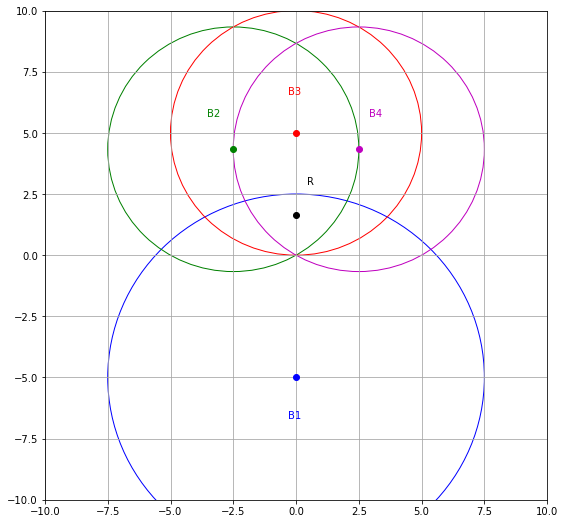

In [64]:
circle1 = plt.Circle(positions[0],distances[0],color='b',fill=False)
circle2 = plt.Circle(positions[1],distances[1],color='g',fill=False)
circle3 = plt.Circle(positions[2],distances[2],color='r',fill=False)
circle4 = plt.Circle(positions[3],distances[3],color='m',fill=False)

fig = plt.figure(figsize=(9,9))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.plot(positions[0][0], positions[0][1], 'bo')
plt.figtext((positions[0][0] + 10)/20, (positions[0][1] + 10)/20, "B1", color='b')
plt.plot(positions[1][0], positions[1][1],'go')
plt.figtext((positions[1][0] + 10)/20, (positions[1][1] + 10)/20, "B2", color='g')
plt.plot(positions[2][0], positions[2][1],'ro')
plt.figtext((positions[2][0] + 10)/20,(positions[2][1] + 10)/20, "B3", color='r')
plt.plot(positions[3][0], positions[3][1],'mo')
plt.figtext((positions[3][0] + 10)/20,(positions[3][1] + 10)/20, "B4", color='m')
fig.gca().add_artist(circle1)
fig.gca().add_artist(circle2)
fig.gca().add_artist(circle3)
fig.gca().add_artist(circle4)
plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.plot(least_squares_sol[0],least_squares_sol[1],'ko')
plt.figtext((least_squares_sol[0] + 10)/20 + 0.03, (least_squares_sol[1] + 10)/20 + 0.03, "R", color='k')

Now that we have seen that linearizing and solving least squares does not always do well, let's try something else.
For any candidate location of the receiver, we can define its distances from each of the beacons:

$$\vec{\hat{d}} = \begin{bmatrix}\hat{d}_1\\\hat{d}_2\\\hat{d}_3\\\hat{d}_4\end{bmatrix}$$

So we might want to minimize the following:

$$\sum_{i=1}^4(d_i-\hat{d}_i)^2$$

Let's see some plots that help us visualize this. $(x,y)$ in the plot correspond to candidate positions of the receivers and $z$ corresponds to the cost.
You can move your cursor over the interactive surface plot and determine where this cost is minimized.
It will generally be minimized at $(0,0)$! (And most importantly, it is less at $(0,0)$ than it was at the least-squares-minimizing position.)

In [65]:
def squared_distance_between_points(pt1, pt2):
    return (pt1[0] - pt2[0])*(pt1[0] - pt2[0]) + (pt1[1] - pt2[1])*(pt1[1] - pt2[1])

def cost_function(measured_distances, actual_distances):
    error = measured_distances - actual_distances
    cost = 0
    for i in range(len(error)):
        cost = cost + error[i]*error[i]
    return cost

xvals = np.linspace(-10,10,200)
yvals = np.linspace(-10,10,200)

x, y = np.meshgrid(xvals,yvals)

In [66]:
zvals = np.zeros([200,200])

for i in range(200):
    for k in range(200):
        pt = [xvals[i],yvals[k]]
        actual_distances = np.zeros(4)
        for j in range(4):
            actual_distances[j] = np.sqrt(squared_distance_between_points(pt,[positions[j][0],positions[j][1]]))
        zvals[i][k] = cost_function(distances,actual_distances)
    

blue=[[0, 'rgb(0,0,255)'], [1, 'rgb(0,0,255)']]
green=[[0, 'rgb(0,255,0)'], [1, 'rgb(0,255,0)']]
red=[[0, 'rgb(255,0,0)'], [1, 'rgb(255,0,0)']]

trace1 = Surface(z=zvals, x=xvals,y=yvals, colorscale=blue,name='Cost')
data = Data([trace1])
fig = Figure(data=data,layout=layout)
py.iplot(fig, filename='triangulation')